# Scaling Laws in Linear Models

In this notebook, we're going to go on a bit of a scavenger hunt. We're going to see all the different power law behevior that linear models can exhibit. We'll see that this depends in particular on two exponents that characterize the dataset: the source and the capacity.

In [13]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

sns.set_style('whitegrid')

!nvidia-smi

Wed Aug  7 12:53:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   69C    P0              31W /  72W |  17311MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

You don't really need a GPU for this notebook

In [ ]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-5, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if (abs(f(x_next)) < abs_tol) or (abs(f(x_next)) < rel_tol * gf(x)):
            return x_next
        x = x_next
    return None

def solve_kappa(q, lamb, etaX, upper_bound=None, anneal_steps=1, **kwargs):
  if not upper_bound:
    upper_bound = lamb + 1e3
  if lamb == 0 and q <= 1:
    return 0
  if lamb == 0 and q > 1:
    fn = lambda kappa: 1 - q * df_1(etaX, kappa)
    return newton(fn, x0=0.0, **kwargs)

  anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
  kappa = upper_bound
  for anneal_lamb in anneal_schedule:
    fn = lambda kappa: kappa * (1 - q * df_1(etaX, kappa)) - anneal_lamb
    kappa_next = newton(fn, x0=kappa, **kwargs)
    if not kappa_next:
      print("Annealing didn't find kappa. Returning last value.")
      return kappa
    kappa = kappa_next
  return kappa

def estimate_df1(lamb, X_tr):
  P, D = X_tr.shape
  q = D/P
  if q >= 1:
    gram = X_tr @ X_tr.T / P
    return jnp.trace(jnp.linalg.solve(gram + lamb*np.identity(P), gram)) / D
  else:
    cov = X_tr.T @ X_tr / P
    return jnp.trace(jnp.linalg.solve(cov + lamb*np.identity(D), cov)) / D

def estimate_df1_S(lamb, X_tr):
  P, D = X_tr.shape
  q = D/P
  if q >= 1:
    gram = X_tr @ X_tr.T / P
    df1 = jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)) @ gram)/D
    S = (lamb * jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)))/P)**(-1)
    return df1, S
  else:
    cov = X_tr.T @ X_tr / P
    df1 = jnp.trace(jnp.linalg.inv(cov + lamb*np.identity(D)) @ cov)/D
    S = 1/(1-q * df1)
    return df1, S

In [ ]:
def simulate_theory(D, qs, lambs, sigma_epsilon, spectrum, teacher, X_te, y_te, num_X_seeds):
    if type(lambs) != list:
        lambs = [lambs]*len(qs)
    data = {}
    S = jnp.diag(spectrum)
    for i in tqdm(range(len(qs))):
        q, lamb  = qs[i], lambs[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, X_te.shape[0]))
        df1_empirical = np.zeros(num_X_seeds)
        kappa_GCV = np.zeros(num_X_seeds)
        Etrs = np.zeros(num_X_seeds)
        for X_seed in range(num_X_seeds):
            key = random.PRNGKey(X_seed)
            X_tr_key, e_key = random.split(key)
            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ (S**0.5)
            y_tr = X_tr @ teacher + epsilon
            y_tr_clean = X_tr @ teacher

            if P > D:
                cov = X_tr.T @ X_tr/P
                w_star = jnp.linalg.solve(cov + lamb*np.identity(D), X_tr.T @ y_tr/P)
                w_star_clean = jnp.linalg.solve(cov + lamb*np.identity(D), X_tr.T @ y_tr_clean/P)
                y_hat_tr = X_tr @ w_star
                Etrs[X_seed] = jnp.mean((y_tr - y_hat_tr)**2)
            else:
                gram = X_tr @ X_tr.T/P
                w_star = X_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr)/P
                w_star_clean = X_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr_clean)/P
                Etrs[X_seed] = lamb**2/P * jnp.sum((jnp.linalg.solve(gram + lamb*np.identity(P), y_tr))**2)

            y_hats[X_seed, :] = X_te @ w_star
            y_hats_clean[X_seed, :] = X_te @ w_star_clean

            df1_emp, S_emp = estimate_df1_S(lamb, X_tr)
            df1_empirical[X_seed] = df1_emp
            kappa_GCV[X_seed] = lamb * S_emp

        Eg = np.mean((y_hats - y_te[None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias = np.mean((y_te - np.mean(y_hats_clean, axis=0))**2)
        VarX = np.mean((y_hats_clean - y_te[None, :])**2, axis=-1) - Bias
        VarXe = Noise
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': Noise,
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT


def solve_theory(qs, lambs, sigma_epsilon, spectrum, teacher, anneal_steps=0, **kwargs):
    if type(lambs) != list:
        lambs = np.array([lambs]*len(qs))
    upper_bounds = lambs + np.mean(spectrum)*qs
    kappa = jnp.array([solve_kappa(q, lamb, spectrum,
                        anneal_steps=anneal_steps, upper_bound=bd, **kwargs)
                        for q, lamb, bd in zip(qs, lambs, upper_bounds)])
    df1 = jnp.array([df_1(spectrum, k) for k in kappa])
    Ss = jnp.array([1/(1-q*df_1(spectrum, k)) for q,k in zip(qs, kappa)])
    Ss = jnp.where((lambs == 0) & (qs > 1), jnp.inf, Ss)
    df2 = jnp.array([df_2(spectrum, k) for k in kappa])
    tf1p = jnp.array([tf_1p(spectrum, teacher, k) for k in kappa])
    gamma = qs * df2

    bias = kappa**2 * tf1p
    varX = kappa**2 * tf1p * gamma/(1-gamma)
    noise = sigma_epsilon**2 * gamma/(1-gamma)
    signal = bias + varX
    Eg = signal + noise
    Etr = (1/Ss)**2 * (Eg + sigma_epsilon**2)
    data = {
        'kappa': kappa,
        'df1': df1,
        'S': Ss,
        'df2': df2,
        'tf1p': tf1p,
        'gamma': gamma,
        'Bias': bias,
        'VarX': varX,
        'VarXe': noise,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

## Unstructured Linear Regression

We begin with the simple case where $\Sigma$ is the identity. That is, the data has no structure. We sometimes call this the *isotropic data setting* This won't exhibit many rich scaling behaviors but nonetheless this is often the first setting people look at. See https://arxiv.org/abs/1710.03667 for pioneering work in this setting.

In [ ]:
# Input dimension
D = 250
# Held out test set
P_te = 100
# We sweep over the overparameterization ratio q
qs = np.logspace(-2, 2, 21)
qs2 = jnp.logspace(-2, 2, 21)
# The ridge that we use
lamb = 1e-3
# The noise level
sigma_epsilon = 0.5
# The number of times we'll redo each regression to get error bars
num_seeds = 50

# Spectrum (trivial here, all 1)
etas = jnp.arange(1, D+1)**(0)
S = jnp.diag(etas)
# Decay of the teacher (again trivial)
w = jnp.arange(1, D+1)**(0)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(42)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

# Run the experiment and the get the theory curves
expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=5, abs_tol=1e-3)

100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


Below we plot how several key quantities of interest change as we vary $q$. Appreciate or show the following:

* $\kappa$ (defined exactly as in the last notebook) does not depend on $y$, $w$ or  $\sigma_\epsilon$.
* $df_1$ is decreasing in $\lambda$ and decreasing in $q$. Similar for $df_2$
* When $q<1$ (underparameterized regime) $\kappa \sim \lambda$. When $q > 1$ and $\lambda$ is small, $\kappa \sim q-1$. This is exactly the *implicit regularization of high dimensional regression
* $\gamma = q df_2$ will turn out to control double descent. Observe that it peaks at $q=1$ and then is surpressed away from this.


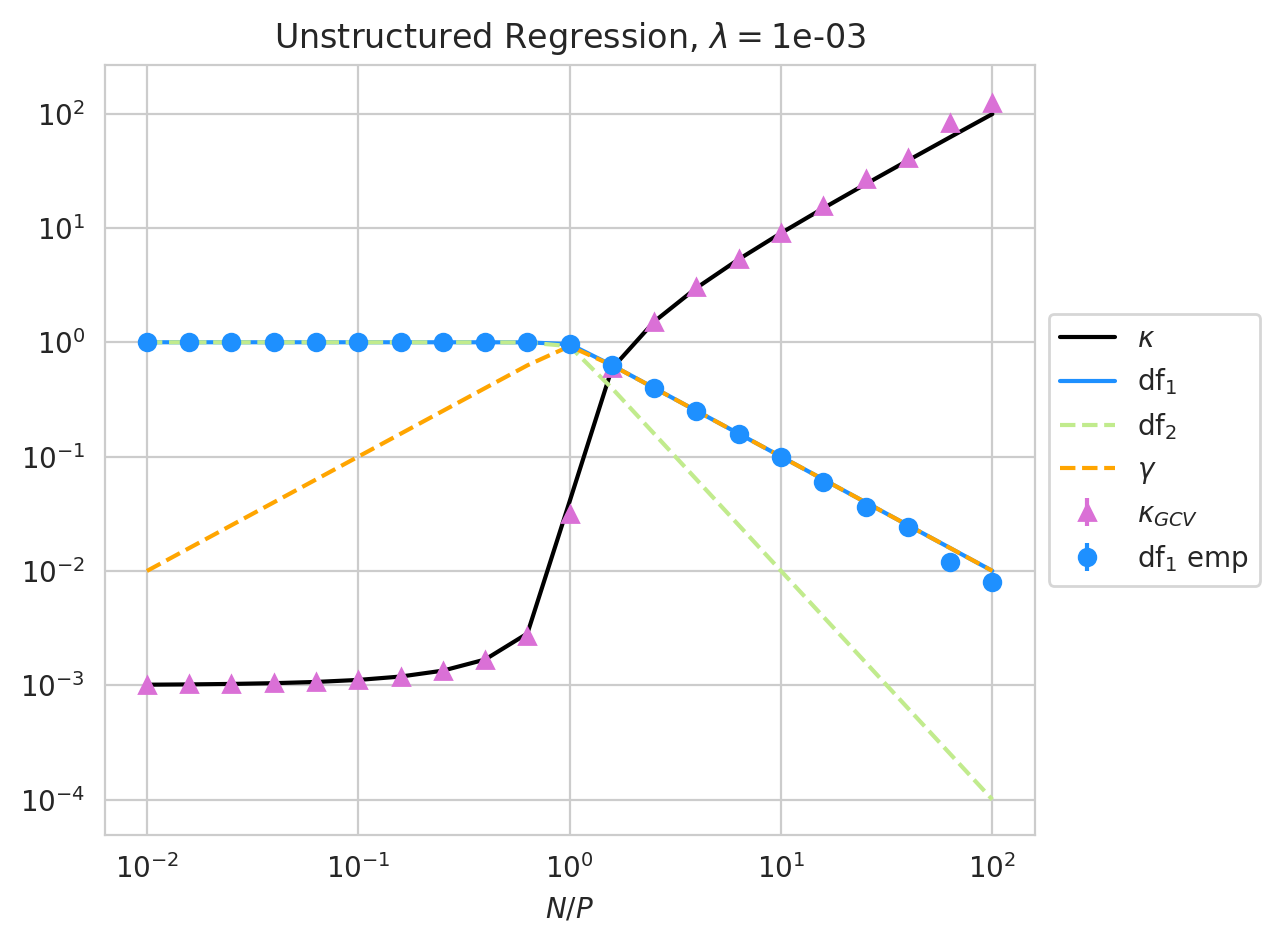

In [ ]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, thry['kappa'], label="$\\kappa$", c='k')
plt.errorbar(qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(qs2, thry['df1'], label="df$_1$", c='dodgerblue')
plt.errorbar(qs, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1$ emp", c='dodgerblue')
plt.plot(qs2, thry['df2'], label="df$_2$", c='C4', ls='--')
plt.plot(qs2, thry['gamma'], label="$\\gamma$", c='orange', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N/P$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/unstructured_LR_params_NP.pdf', bbox_inches='tight')

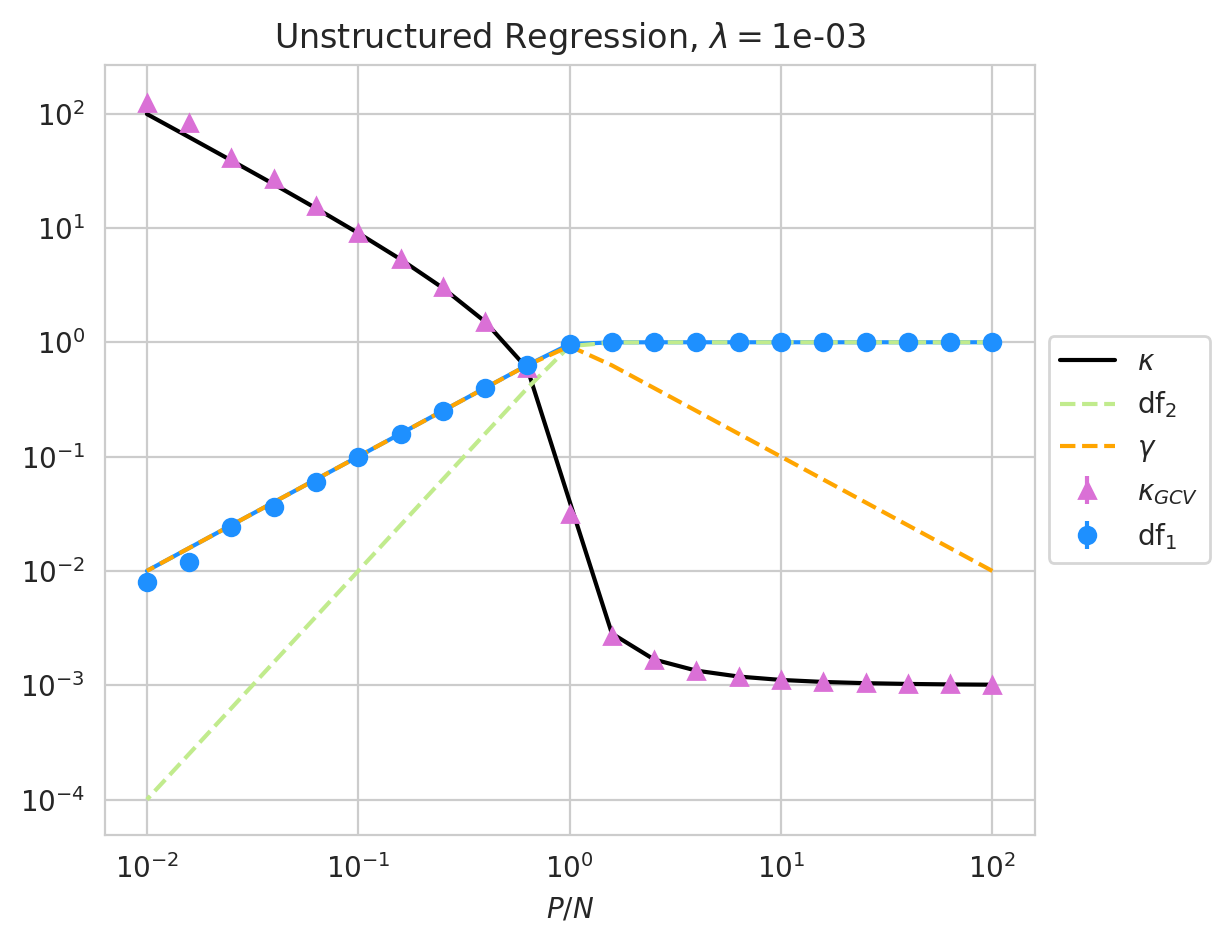

In [ ]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(1/qs2, thry['kappa'], label="$\\kappa$", c='k')
plt.errorbar(1/qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(1/qs2, thry['df1'], c='dodgerblue')
plt.errorbar(1/qs, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1$", c='dodgerblue')
plt.plot(1/qs2, thry['df2'], label="df$_2$", c='C4', ls='--')
plt.plot(1/qs2, thry['gamma'], label="$\\gamma$", c='orange', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P/N$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/unstructured_LR_params_PN.pdf', bbox_inches='tight')

Full plot of training error, generalization error, and various sources of variance. Play around with this at different values of $\lambda, \sigma_\epsilon$

Observe the following
* Training error is of order $\lambda^2$ when $N > P$ (overparameterized). That's because in the overparameterized regime we can interpolate the data in the ridgeless limit. When $P > N$ the training error remains finite
* The bias is small when $P > N$. That's because at zero ridge the linear model is an unbiased estimator in the underparameterized regime. Not so in the $N > P$ regime. Finite $\kappa$  is obligatory there, and introduces a bias.
* You can estimate the generalization error from the data very well using the generalized cross validation: $$ E_g = S^2 E_{tr}$$

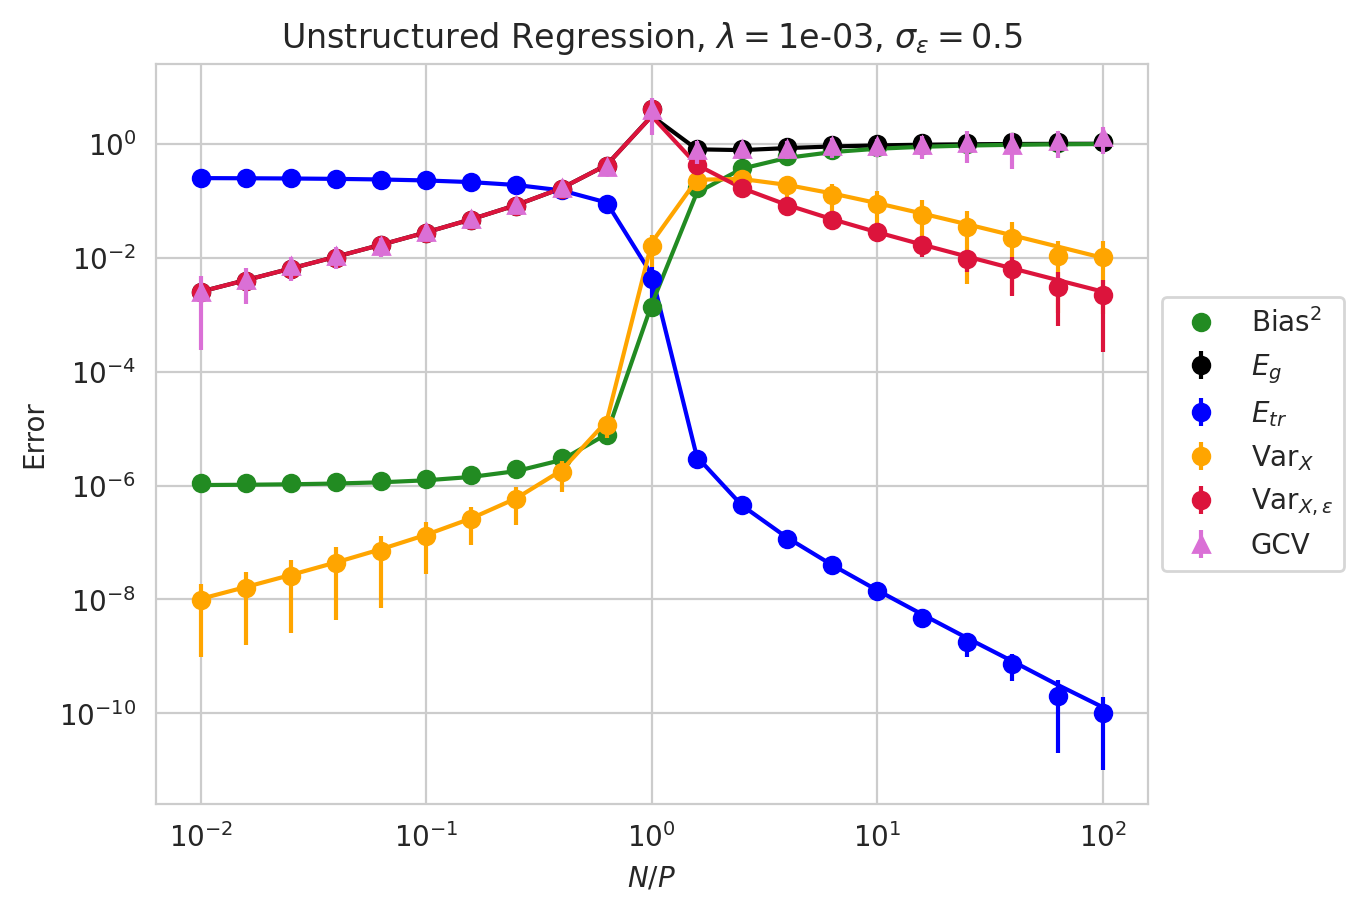

In [ ]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarXe']
colors = ['k', 'b', 'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(qs, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(qs, E_GCV, E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$N/P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-7,2)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig
plt.savefig('figures/unstructured_LR_logspace.pdf', bbox_inches='tight')

The same, but as a linear-linear plot and in terms of P/N:

In [ ]:
lamb = 1e-3
sigma_epsilon = 0.5
qs =  1/np.linspace(0.1, 2.0, 20)
qs2 = 1/np.linspace(0.05, 2.0, 40)
expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=5, abs_tol=1e-5)

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


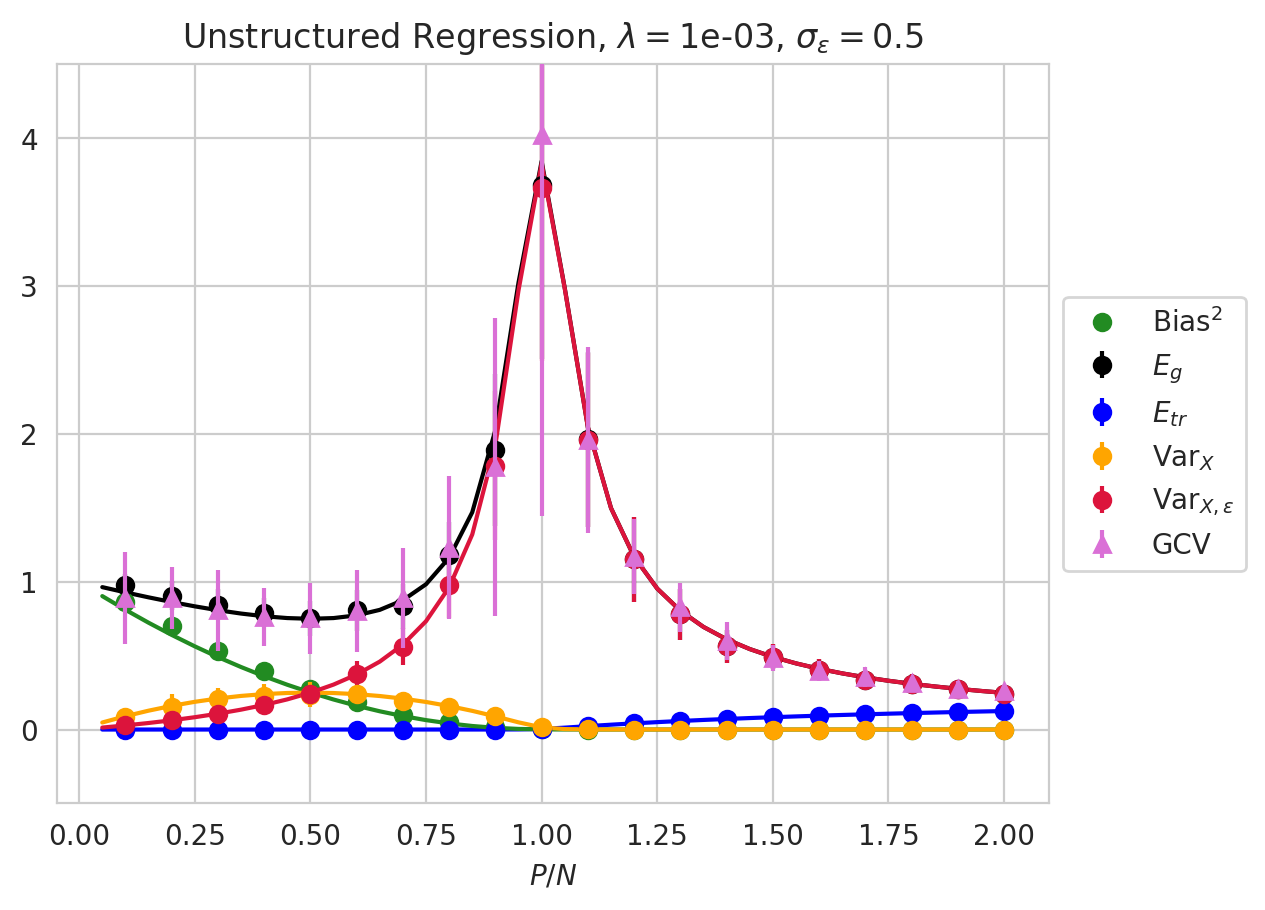

In [ ]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarXe']
colors = ['k', 'b', 'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], expt[key+'_std'], c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

plt.errorbar(1/qs, (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2, (expt['kappa_GCV']/lamb)**2 * expt['Etr_std'], c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$P/N$')
plt.ylim(-0.5, 4.5)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/unstructured_LR_linspace.pdf', bbox_inches='tight')

## Structured Linear Regression

At last we get to scaling laws. Here, $\Sigma$ is no longer the identity. Now we define two exponents:

1. The *capacity exponent* $\alpha$ which is the decay rate of the eigenvalues of $\Sigma$, ie: $$\eta_k \sim k^{-\alpha}$$
2. The *source expoennt* $r$ which is related to how $w$ decays along each eigenmode. Specifically we have:
$$ \eta_k w_k^2 \sim k^{-(2 \alpha r + 1)} $$
This may look like a bit of a weird way to define $r$ but all formulas will simplify substantially in terms of this.

In [ ]:
D = 10_000
num_seeds = 30

qs = np.logspace(1, 4, 20)
qs2 = qs
ps = D/qs
ps2 = D/qs2

# Source and capacity exponents
r = 1.8
alpha = 2.0

sigma_epsilon = 0.0
lamb = 1e-4
etas = jnp.arange(1, D+1)**(-alpha)
S = jnp.diag(etas)
w = jnp.arange(1, D+1)**(-(1 + alpha * (2*r - 1))/2)
w = w / jnp.sqrt(jnp.sum(w**2))

P_te = 200
X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=4)

100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Play around with thing and make the following observations:

1. $\kappa$ is a decreasing function of $P$. That makes sense: more data improves the resolution that we can resolve the data manifold.
1. At small $\lambda$ we have $\kappa \sim P^{-\alpha}$. **This scaling is crucial**. More generall $\kappa \sim \mathrm{min}(\lambda, P^{-\alpha})$. This is an example of what I call *Murphy's law of the resolution*. Whatever can bottleneck the resolution *will* bottleneck the resolution. In more general models that also have a number of parameters $N$, this also enters as the other bottleneck. This is at the heart of the chinchalla-type parameter vs data scaling.   
1.  Things get a bit wonky when $\alpha < 1$. This corresponds to a *non-normalizable spectrum* which is not observed in real data. We do not consider this setting.


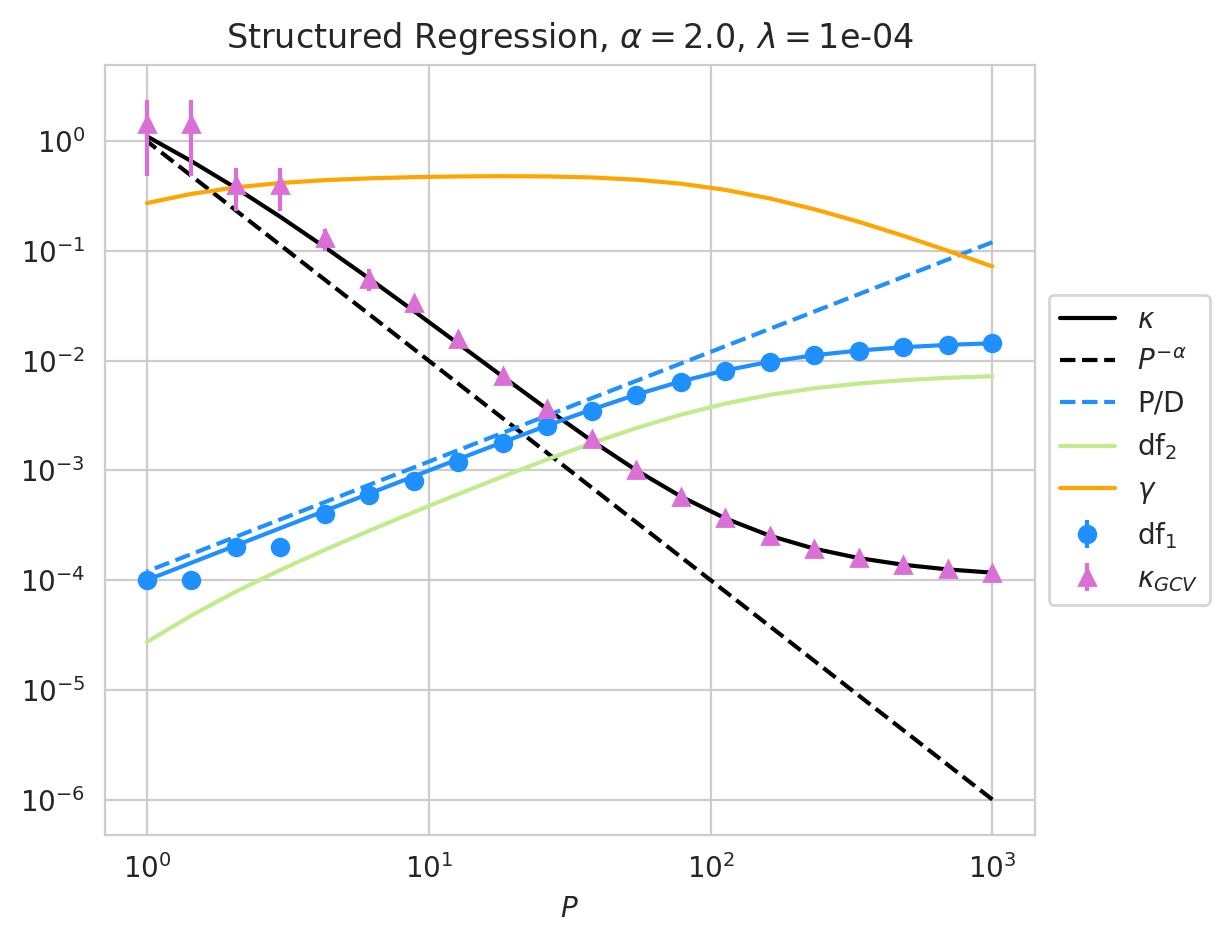

In [ ]:
title = f'structured_LR_alpha={alpha}_params'

plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa'], label="$\\kappa$", c='k')
plt.plot(ps2, 1e0*(qs2/D)**(alpha), c='black', linestyle='--', label='$P^{{-\\alpha}}$')

plt.plot(ps2, thry['df1'], c='dodgerblue')
plt.errorbar(ps2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1$", c='dodgerblue')
plt.plot(ps2, 1/qs2*(1+2e-1), label="P/D", c='dodgerblue', ls='--')

plt.plot(ps2, thry['df2'], label="df$_2$", c='C4')
plt.plot(ps2, thry['gamma'], label="$\\gamma$", c='orange')
plt.errorbar(ps2, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P$')
plt.title(f"Structured Regression, $\\alpha=${alpha}, $\\lambda=${lamb:.0e}")
plt.savefig(f'figures/{title}.pdf', bbox_inches='tight')



# Noiseless Scaling Laws
Play around with things, keeping $\sigma_\epsilon = 0$ Show the following:
* When $r > 1$ we have $E_g \sim \kappa^2 = P^{-2 \alpha}$.
* When $r < 1$ we have $E_g \sim P^{-2 \alpha r}$

That is, depending on whether the task is super easy ($r > 1$) or hard ($r < 1$, what most data is) we get different scaling laws.

These scaling laws were obtained by Spigler et al in https://arxiv.org/abs/1905.10843 and Bordelon et al in: https://arxiv.org/abs/2002.02561

These constitute the nontrivial *resolution limited scalings* proposed in Bahri et al: https://arxiv.org/abs/2102.06701

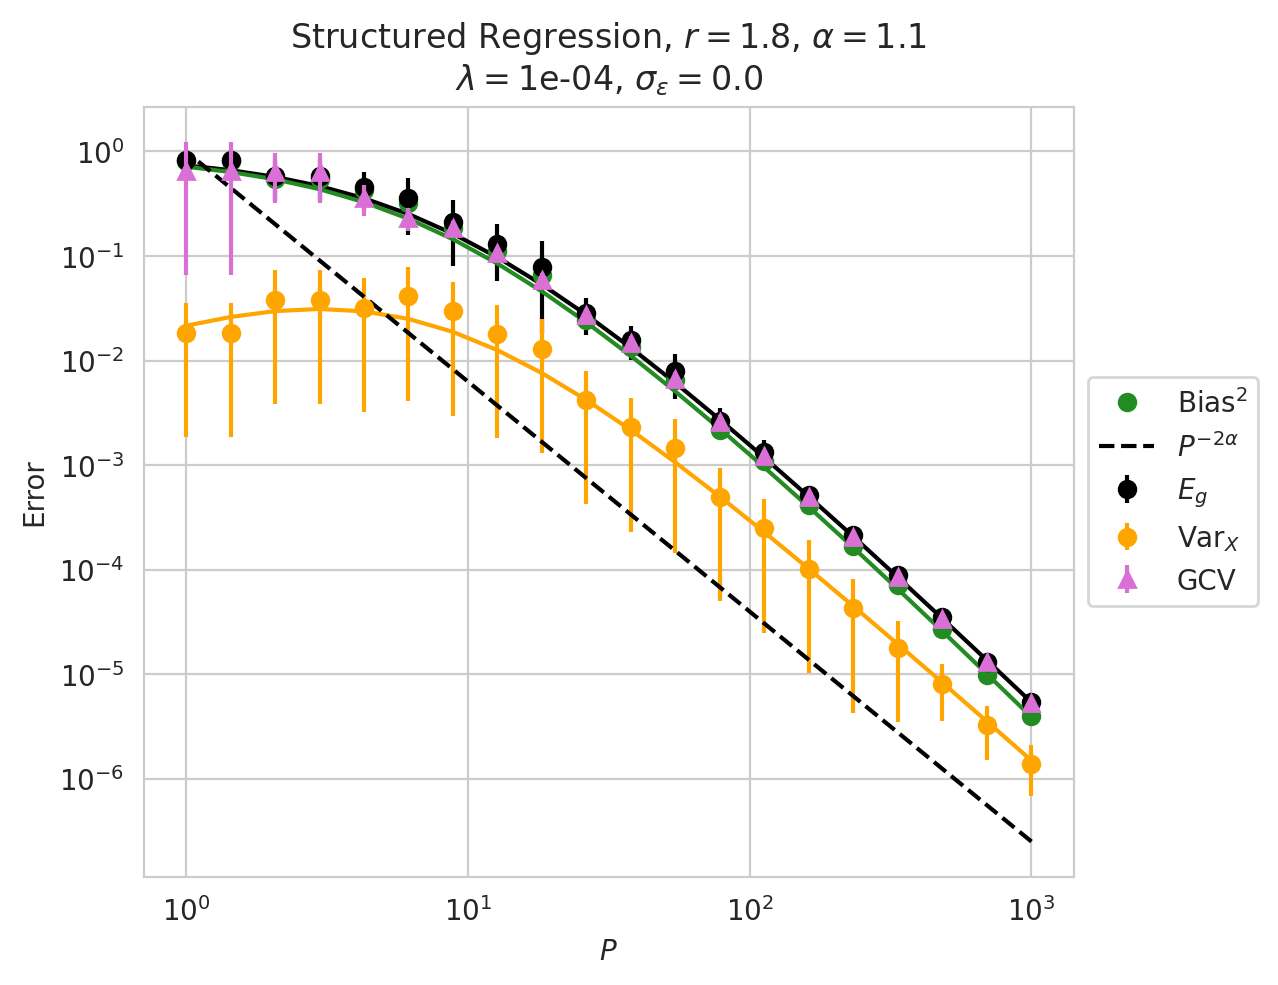

In [ ]:
title = 'structured_LR_source' if r < 1 else 'structured_LR_capacity'

plt.figure(figsize=(6, 5))
keys = ['Eg', 'Bias', 'VarX']
colors = ['k',  'forestgreen', 'orange']
labels = ["$E_g$", "Bias$^2$", "Var$_X$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

Eg_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
S = expt['kappa_GCV']/lamb
plt.errorbar(ps, S**2 * expt['Etr'] - sigma_epsilon**2, np.minimum(S**2 * expt['Etr_std'], 0.9*Eg_GCV), c='orchid', marker='^', linestyle='', label='GCV', zorder=3)
lbl = '$P^{{-2\\alpha}}$' if r > 1 else '$P^{{-2\\alpha r}}$'
plt.plot(ps2, (ps2)**(-2*alpha*min(r, 1)), c='black', linestyle='--', label=lbl)

plt.xlabel(r'$P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(8e-5, 8e-2)
plt.title(f"Structured Regression, $r=${r}, $\\alpha=${alpha}\n$\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'figures/{title}.pdf', bbox_inches='tight')

## Extra credit: Scaling Laws under Noise
1. Add noise $\sigma_\epsilon$. What happens to the scaling law now? You likely will observe a plateau. When does it happen? (Hint: compare the noiseless scaling laws to  the noise).
2. Is there a way to avoid hitting this plateau at large $P$? (Hint: what happens if you change the explicit ridge $\lambda$?)
3. Explicit ridge may change where the plateau is, but you still hit a plateau. Consider instead scaling $\lambda \sim P^{-l}$.

See Cui et al for details: https://proceedings.neurips.cc/paper/2021/file/543bec10c8325987595fcdc492a525f4-Paper.pdf


## Scaling Laws for SGD

We now turn our attention to *dynamics*. We focus on the *online SGD* setting where at each step of SGD we are provided with a fresh batch of data (ie data is never repeated). This is common in modern language modeling, where often *compute* and note data is the bottleneck.

In [27]:
import optax
D = 10_000
num_seeds = 30
# Source and capacity exponents
r = 0.8
alpha = 1.5

etas = jnp.arange(1, D+1)**(-alpha)
S = jnp.diag(etas)
w = jnp.arange(1, D+1)**(-(1 + alpha * (2*r - 1))/2)
w = w / jnp.sqrt(jnp.sum(w**2))

# Learning rate, batch size, time steps
T = 5000
B = 32
lr = 0.5

tx = optax.sgd(lr)
params = jnp.zeros(D)
opt_state = tx.init(params)

@jax.jit
def loss_fn(params, X_tr, y_tr):
    y_hat = X_tr @ params
    return jnp.mean((y_hat - y_tr)**2)

losses = []
for t in tqdm(range(T)):
    X_tr = random.normal(random.PRNGKey(t), (B, D)) @ jnp.sqrt(S)
    y_tr = X_tr @ w
    loss, grads = jax.value_and_grad(loss_fn)(params, X_tr, y_tr)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    losses.append(loss)



100%|██████████| 5000/5000 [00:26<00:00, 191.82it/s]


You should see a very clean trend: $L \sim t^{-2r}$.
Let's actually explain this scaling law from first princples!

1. Let $\bar w$ be the teacher and $w^*$ be th elearned weights at time $t$. Show $\Delta w \equiv (\bar w - w^*) $ satisfies $\frac{d}{dt} \Delta w =- 2 \eta \Sigma \Delta w$ and thus $\Delta w(t) = e^{-2\eta \Sigma t} \bar w$  
2. Consequently, show that for SGD, the time to "learn" eigenmode $k$ goes as $1/\lambda_k$.
3. Show that the generalization error in this task is $L(t) = (\bar w - w^*)^\top \Sigma (\bar w - w^*)$. Write this as as an integral over the spectrum of $\Sigma$:
$$L(t) = \int d\rho(\lambda)  \lambda \bar w(\lambda)^2 e^{-2 \eta \lambda t}  $$
Here $\bar w(\lambda)$ is how much of the signal is in eigenmode $\lambda$.  
4. It is straightforward to show that $d \rho(\lambda) = \lambda^{-1-1/\alpha}$. Using the definition of the source, show that $\lambda \bar w(\lambda)^2 = \lambda^{(1+2 \alpha r)/\alpha}$. Now, do the exponential integral over $\lambda$.



Text(0, 0.5, 'Loss')

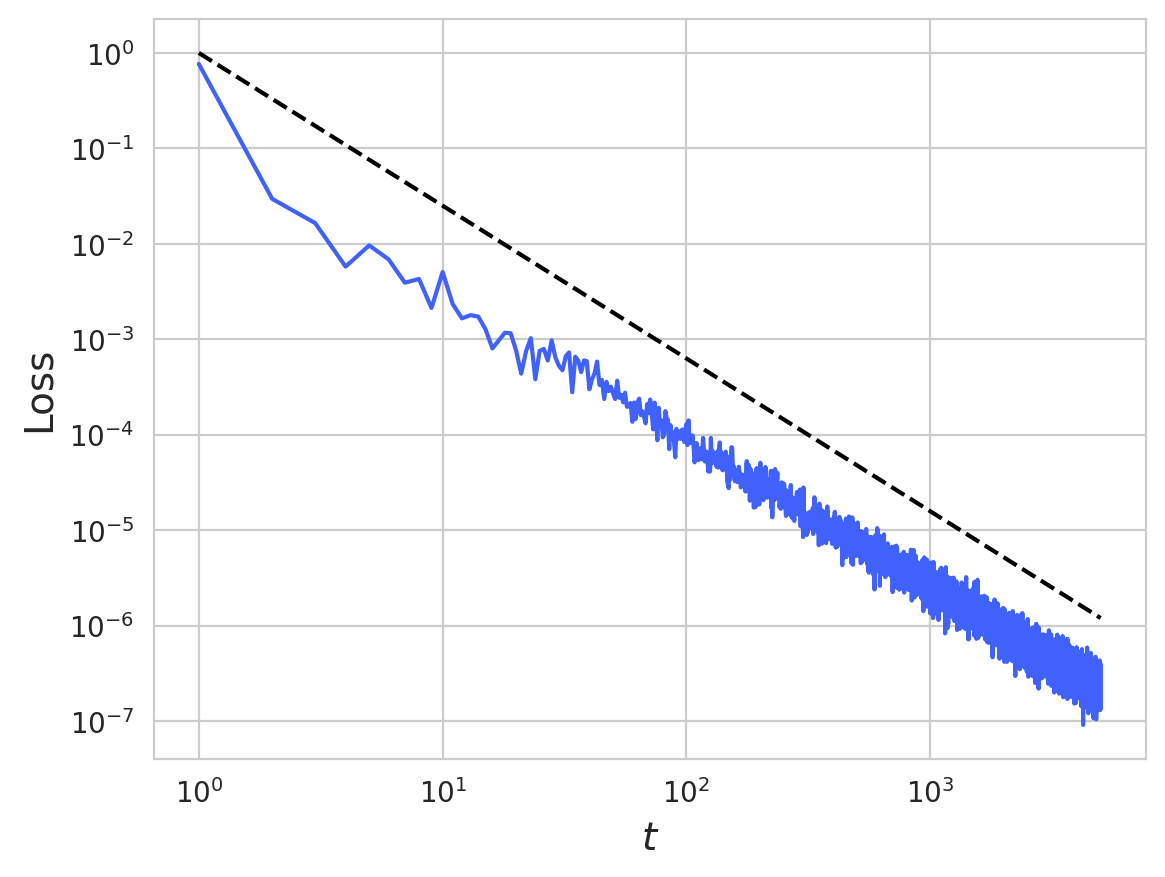

In [28]:
ts = np.arange(1, T+1)
plt.loglog(ts, losses)
plt.loglog(ts, ts**(-2*r), 'k--')
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Loss", fontsize=14)



Extra credit:
*  Can you break this scaling law? If so, under what conditions on $r, \alpha$.
*  What do you think leads to its breaking?